In [1]:
import ROOT as rt
import csv
import re
import sys
import collections
from collections import OrderedDict
import uproot
import numpy as np
import time
import numba
from numba import jit
from matplotlib import pyplot as plt
from numpy import linalg as LA
from ROOT import TLorentzVector
from array import array
# import PyTEX
import os

import math
import random
from optparse import OptionParser

sys.path.append('/storage/user/jmao/gpu/jmao/cms-llp/delayed_jet_analyzer/lib/')

from histo_utilities import create_TH1D, create_TH2D, create_TGraph,std_color_list, make_ratio_plot

import CMS_lumi, tdrstyle 
tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 1
CMS_lumi.extraText = "     Simulation Preliminary"

     
print(sys.version)

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score
import pandas as pd
import pickle as pickle
import shlex
import uproot
import seaborn as sns

from scipy.spatial.distance import cdist
from collections import Counter 
import datetime
import pytz

from prettytable import PrettyTable
from pyjet import cluster

import xgboost as xgb
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from xgboost import XGBClassifier


Welcome to JupyROOT 6.22/02
3.6.8 (default, Apr  2 2020, 13:34:55) 
[GCC 4.8.5 20150623 (Red Hat 4.8.5-39)]


In [2]:
# root settings
rt.gROOT.SetBatch(True)
rt.gStyle.SetOptStat(0)
rt.gStyle.SetOptFit(111)
rt.gStyle.SetPaintTextFormat("2.1f")

# plt.rcParams["font.family"] = "Arial"
plt.rcParams["axes.unicode_minus"] = False
plt.rcParams["text.usetex"] = False
plt.rcParams["mathtext.fontset"] = "cm"

# test_name = 'xgb_HH_vs_QCD_ebBDT'

lumi_sf_sig = 137.0 # scale lumi from sample to full run2
lumi_sf_bkg = 137.0

#output dir


# plotDir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20210119/2018/Mu/'
plotDir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20210218/2018/Mu/'

os.system("mkdir -p "+ plotDir)

0

# Load root files

In [37]:
tags = []
tags = [
    
#         'Data 2018 SingleMuon',
#         'MC 2018 WJets_Mu',

#         'Data 2018 Zmumu',
#         'MC 2018 Znunu',
    
#         'Data 2018 JetHT',
#         'MC 2018 QCD',
    
#         'Data 2018 MuonEG',
#         'MC 2018 TTJets',

#         'Data 2018 MetAna',
#         'MC 2018 QCD MetAna',
#         'MC 2018 WLNuJets MetAna',
#         'MC 2018 ZNuNu MetAna',
#         'MC 2018 TTJets MetAna',
    
        'Data 2018 MetAna',    
        'Data 2018 SingleMuon',
        'Data 2018 Zmumu',    
        'Data 2018 JetHT',    
        'Data 2018 MuonEG',
 
        ]

# directory
home_dir = '/mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetTimingAnalyzer/'
# file names

fnames = {}


fnames['Data 2018 SingleMuon'] = 'V1p17/v26/Data2018_AOD/SingleMuon/normalized/Run2_displacedJetMuonNtupler_V1p17_Data2018_Run2018-17Sept2018.root'
fnames['MC 2018 WJets_Mu'] = 'V1p17/v26/MC_Fall18/normalized/WJetsToLNu_HT-70ToInf_TuneCP5_13TeV-madgraphMLM-pythia8_1pb_weighted.root'


fnames['Data 2018 Zmumu'] = 'V1p17/v26/Data2018_AOD/Zmumu/normalized/Run2_displacedJetMuonNtupler_V1p17_Data2018_Run2018-17Sept2018.root'
fnames['MC 2018 Znunu'] = 'V1p17/v26/MC_Fall18/normalized/ZJetsToNuNu_HT-100ToInf_13TeV-madgraph_1pb_weighted.root'


fnames['Data 2018 MuonEG'] = 'V1p17/v26/Data2018_AOD/MuonEG/normalized/Run2_displacedJetMuonNtupler_V1p17_Data2018_Run2018-17Sept2018.root'
fnames['MC 2018 TTJets'] = 'V1p17/v26/MC_Fall18/normalized/TTJets_TuneCP5_13TeV-madgraphMLM-pythia8_1pb_weighted.root'


fnames['Data 2018 JetHT'] = 'V1p17/v27/Data2018_AOD/JetHT/normalized/Run2_displacedJetMuonNtupler_V1p17_Data2018_Run2018-17Sept2018.root'
fnames['MC 2018 QCD'] = 'V1p17/v27/MC_Fall18/normalized/QCD_HT50toInf_TuneCP5_13TeV-madgraphMLM-pythia8_1pb_weighted.root'


fnames['Data 2018 SingleMuon'] = 'V1p17/v26/Data2018_AOD/SingleMuon/normalized/Run2_displacedJetMuonNtupler_V1p17_Data2018_Run2018-17Sept2018.root'
fnames['MC 2018 WJets_Mu'] = 'V1p17/v26/MC_Fall18/normalized/WJetsToLNu_HT-70ToInf_TuneCP5_13TeV-madgraphMLM-pythia8_1pb_weighted.root'

fnames['Data 2018 MetAna'] = 'V1p17/v26/MetAna/Data2018/normalized/Run2_displacedJetMuonNtupler_V1p17_Data2018_Run2018-HighMET-17Sept2018.root'
fnames['MC 2018 QCD MetAna'] = 'V1p17/v26/MetAna/MC_Fall18/normalized/QCD_HT50toInf_TuneCP5_13TeV-madgraphMLM-pythia8_1pb_weighted.root'
fnames['MC 2018 WLNuJets MetAna'] = 'V1p17/v26/MetAna/MC_Fall18/normalized/WJetsToLNu_HT-70ToInf_TuneCP5_13TeV-madgraphMLM-pythia8_1pb_weighted.root'
fnames['MC 2018 ZNuNu MetAna'] = 'V1p17/v26/MetAna/MC_Fall18/normalized/ZJetsToNuNu_HT-100ToInf_13TeV-madgraph_1pb_weighted.root'
fnames['MC 2018 TTJets MetAna'] = 'V1p17/v26/MetAna/MC_Fall18/normalized/TTJets_TuneCP5_13TeV-madgraphMLM-pythia8_1pb_weighted.root'


In [38]:
# get all the trees
tree = OrderedDict()

for tag in tags:
    print(home_dir+fnames[tag])

    root_dir = uproot.open(home_dir+fnames[tag])
    tree[tag] = root_dir['SusyLLPPFTree']

    print ('Open ready')
    print(tag)
    print ('Tree ready')
    print(tree[tag], tree)
    v = tree[tag]
    jet_amax = v['jetPt'].array()
    print(jet_amax[:10])
    jet_amax = v['weight'].array()
    print(jet_amax[:10])
    print(np.unique(jet_amax))
    jet_amax = v['pileupWeight'].array()
    print(np.unique(jet_amax))
     

/mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetTimingAnalyzer/V1p17/v26/MetAna/Data2018/normalized/Run2_displacedJetMuonNtupler_V1p17_Data2018_Run2018-HighMET-17Sept2018.root
Open ready
Data 2018 MetAna
Tree ready
<TTree b'SusyLLPPFTree' at 0x7fdc4dd991d0> OrderedDict([('Data 2018 MetAna', <TTree b'SusyLLPPFTree' at 0x7fdc4dd991d0>)])
[[252.099 86.69548] [169.24118 101.05952 72.9377 67.27325 56.723362 40.145775] [304.70297] ... [307.73352] [174.49806 162.59258] [102.77982 88.73353]]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1.]
[1.]
/mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetTimingAnalyzer/V1p17/v26/Data2018_AOD/SingleMuon/normalized/Run2_displacedJetMuonNtupler_V1p17_Data2018_Run2018-17Sept2018.root
Open ready
Data 2018 SingleMuon
Tree ready
<TTree b'SusyLLPPFTree' at 0x7fdcc1de0160> OrderedDict([('Data 2018 MetAna', <TTree b'SusyLLPPFTree' at 0x7fdc4dd991d0>), ('Data 2018 SingleMuon', <TTree b'SusyLLPPFTree' at 0x7fdcc1de0160>)])
[[83.34182] [48.265675 32.7489]

# Load branches

In [39]:
# plotDir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20210119/2018/Mu/'
# plotDir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20210119/2018/Zmumu/'
# plotDir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20210127/2018/JetJet/'
# plotDir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20210127/2018/JetJet/jet_dphi_2p8/'
# plotDir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20210127/2018/Data_CR_jetjet_dphi_2p8/'
# plotDir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20210127/2018/Data_CR/'
plotDir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20210218/2018/Data_CR/'
# plotDir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20210119/2018/Emu/'
# plotDir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20210119/2018/MetAna/'

os.system("mkdir -p "+ plotDir)

0

In [40]:

dnn_thre = 0.996

trg_jet_w = {} 
trg_jet_pu = {} 
trg_jet_pt = {}
trg_jet_dphi_jet = {}
trg_jet_dphi_pho = {}
trg_jet_dphi_met = {}

dphi_cut=0

trg_jet_dnn = {}
# trg_jet_pass = {}


for k,v in tree.items():
    print(k,v)

    # branches
    evt = v['evtNum'].array()

    # count branches
    nmu = v['nMuons'].array()
    nele = v['nElectrons'].array()
    
    nlep = v['nLeptons'].array()
    mt = v['MT'].array()
    
    ntau = v['nTaus'].array()
    npho = v['nPhotons'].array()
    njet = v['nJets'].array()
    
    # dphi branches
    met_jet = v['jetMet_dPhiMin'].array()
    pho_jet = v['jetPho_dPhiMin'].array()
    jet_jet = v['jet2_dPhi'].array()
    
    sel_mu_str = np.logical_and(nmu==1, nele==0)
    sel_mu_str = np.logical_and(sel_mu_str, nlep==1)
    sel_mu_str = np.logical_and(sel_mu_str, mt<100)
    sel_mu_str = np.logical_and(sel_mu_str, ntau==0)
    sel_mu_str = np.logical_and(sel_mu_str, npho==0)
    sel_mu_str = np.logical_and(sel_mu_str, njet>0)
    
    sel_mm_str = np.logical_and(nmu==2, nele==0)
    sel_mm_str = np.logical_and(sel_mm_str, nlep==2)
    sel_mm_str = np.logical_and(sel_mm_str, ntau==0)
    sel_mm_str = np.logical_and(sel_mm_str, npho==0)
    sel_mm_str = np.logical_and(sel_mm_str, njet>0)
    
    sel_em_str = np.logical_and(nmu==1, nele==1)
    sel_em_str = np.logical_and(sel_em_str, nlep==2)
    sel_em_str = np.logical_and(sel_em_str, ntau==0)
    sel_em_str = np.logical_and(sel_em_str, npho==0)
    sel_em_str = np.logical_and(sel_em_str, njet>0)
    
    sel_jj_str = np.logical_and(nmu==0, nele==0)
    sel_jj_str = np.logical_and(sel_jj_str, nlep==0)
    sel_jj_str = np.logical_and(sel_jj_str, ntau==0)
    sel_jj_str = np.logical_and(sel_jj_str, npho==0)
    sel_jj_str = np.logical_and(sel_jj_str, njet==2)
    if dphi_cut:
        sel_jj_str = np.logical_and(sel_jj_str, jet_jet>2.8)
        
    sel_met_mc_str = np.logical_and(ntau==0, njet>0)
    sel_met_mc_str = np.logical_and(sel_met_mc_str, evt%2==1)
    
    sel_met_data_str = np.logical_and(nlep==1, mt<100)
    sel_met_data_str = np.logical_and(sel_met_data_str, ntau==0)
    sel_met_data_str = np.logical_and(sel_met_data_str, npho==0)
    sel_met_data_str = np.logical_and(sel_met_data_str, njet>0)        
    
#     if 'Mu' in plotDir:
#         sel_str = sel_mu_str
#     elif 'Zmumu' in plotDir:
#         sel_str = sel_mm_str
#     elif 'Emu' in plotDir:
#         sel_str = sel_em_str
#     elif 'JetJet' in plotDir:
#         sel_str = sel_jj_str
#     elif 'MetAna' in plotDir:
#         if 'MC' in k:
#             sel_str = sel_met_mc_str
#         else:
#             sel_str = sel_met_data_str

    if 'SingleMuon' in k:
        sel_str = sel_mu_str
    elif 'Zmumu' in k:
        sel_str = sel_mm_str
    elif 'MuonEG' in k:
        sel_str = sel_em_str
    elif 'JetHT' in k:
        sel_str = sel_jj_str
    elif 'MetAna' in k:
        if 'MC' in k:
            sel_str = sel_met_mc_str
        else:
            sel_str = sel_met_data_str
        
    
    
    #jet var
    pt = v['jetPt'].array()
    dnn = v['jetDNNScoreV3'].array()
    print(pt[:10])
    print(dnn[:10])
#     if dnn_thre==0.99:
#         pf = v['jetPass'].array()
#     else:
#         pf = dnn
#         np.array(np.where(dnn<= dnn_thre, 0, 1))
 
    weight = v['weight'].array()
    if 'MC' in k:
        pu = v['pileupWeight'].array()
    
    print(weight.shape)
    
    #selection
    
#     trg_jet_pt[k] = pt
#     trg_jet_pass[k] = pf

#     trg_jet_w[k] = weight 
#     if 'MC' in k:
#         trg_jet_pu[k] = pu 

    #dphi var
    trg_jet_dphi_jet[k] = jet_jet[sel_str]
    trg_jet_dphi_pho[k] = pho_jet[sel_str]
    trg_jet_dphi_met[k] = met_jet[sel_str]
    
    #jet var

    trg_jet_pt[k] = pt[sel_str]
    trg_jet_dnn[k] = dnn[sel_str]
#     if dnn_thre==0.99:
#         trg_jet_pass[k] = pf[sel_str]
#     else:
# #         temp = dnn[sel_str]
# #         trg_jet_pass[k] = np.where(temp<= dnn_thre, 0, 1)
#         trg_jet_pass[k] = []
#         for ele in trg_jet_dnn[k]:
#             trg_jet_pass[k].append(np.array(np.where(ele<= dnn_thre, 0, 1)))
#         trg_jet_pass[k] = np.array(trg_jet_pass[k])
#     print(trg_jet_pass[k][:10])

    trg_jet_w[k] = weight[sel_str] 
    if 'MC' in k:
        trg_jet_pu[k] = pu[sel_str] 

    #print out check

    print(len(trg_jet_pt[k]))   
    print(len(trg_jet_dnn[k]))   
#     print(len(trg_jet_pass[k]))
    
    print(len(trg_jet_w[k]))
    if 'MC' in k:
        print(len(trg_jet_pu[k]))
    

Data 2018 MetAna <TTree b'SusyLLPPFTree' at 0x7fdc4dd991d0>
[[252.099 86.69548] [169.24118 101.05952 72.9377 67.27325 56.723362 40.145775] [304.70297] ... [307.73352] [174.49806 162.59258] [102.77982 88.73353]]
[[0.0026412331 0.031475917] [0.0053804447 0.0042757005 0.031419884 0.012517412 0.018457314 0.02286801] [0.0010184451] ... [0.0005431884] [0.0021996745 0.0013575817] [0.0015470696 0.012408396]]
(2271481,)
139077
139077
139077
Data 2018 SingleMuon <TTree b'SusyLLPPFTree' at 0x7fdcc1de0160>
[[83.34182] [48.265675 32.7489] [32.302116] ... [32.336784] [121.321266] [62.650528]]
[[0.004590725] [0.018124666 0.022461142] [0.6224436] ... [nan] [0.015591512] [0.01133574]]
(61684577,)
47486440
47486440
47486440
Data 2018 Zmumu <TTree b'SusyLLPPFTree' at 0x7fdcc2002668>
[[32.200684] [44.587402] [92.988075] ... [42.423134] [42.8758] [33.71453]]
[[nan] [0.018034609] [0.004407792] ... [0.0085775675] [0.023434136] [0.03868038]]
(2578827,)
2505437
2505437
2505437
Data 2018 JetHT <TTree b'SusyLLPP

# Tags

In [41]:

nTags = {}
nJets = {}

tag_jet_pt = {}

pt_cut=30

for k,v in tree.items():
    print(k,v)
    
    nJets[k] = trg_jet_pt[k].count()
    
    #tag cuts
    tagged_jet = np.logical_and(trg_jet_dnn[k]>dnn_thre , trg_jet_pt[k]>pt_cut)
#     tagged_jet = np.logical_and(trg_jet_pass[k] , trg_jet_pt[k]>pt_cut)
 
#     untagged_jet = np.logical_not(tagged_jet) 
    
    nTags[k] = trg_jet_pt[k][tagged_jet].count()
    
    tag_jet_pt[k] = trg_jet_pt[k][tagged_jet] 

    print(trg_jet_pt[k][:10])
    print(tag_jet_pt[k][:10])
    
    print(np.unique(nJets[k]))
    print(np.unique(nTags[k]))
    
    print(len(nTags[k][nTags[k]==1]))
    
    for i,ele in enumerate(nTags[k]):
        if ele > 2:
            nTags[k][i] = 2
            
    print(np.unique(nTags[k]))
    

Data 2018 MetAna <TTree b'SusyLLPPFTree' at 0x7fdc4dd991d0>
[[102.77982 88.73353] [481.46878 194.19504 120.04627 47.10105 36.647835] [528.6866 206.38155] ... [271.896] [230.09985] [332.4251]]
[[] [] [] ... [] [] []]
[ 1  2  3  4  5  6  7  8  9 10]
[0 1]
59
[0 1]
Data 2018 SingleMuon <TTree b'SusyLLPPFTree' at 0x7fdcc1de0160>
[[83.34182] [48.265675 32.7489] [32.302116] ... [62.650528] [30.808998] [36.963013]]
[[] [] [] ... [] [] []]
[ 1  2  3  4  5  6  7  8  9 10 11 12 13]
[0 1 2]
14589
[0 1 2]
Data 2018 Zmumu <TTree b'SusyLLPPFTree' at 0x7fdcc2002668>
[[32.200684] [44.587402] [92.988075] ... [42.8758] [33.71453] [39.783207]]
[[] [] [] ... [] [] []]
[ 1  2  3  4  5  6  7  8 10 11]
[0 1]
792
[0 1]
Data 2018 JetHT <TTree b'SusyLLPPFTree' at 0x7fdc4dd37668>
[[115.26632 77.62634] [720.2655 58.22363] [86.26255 30.66262] ... [385.65317 164.2532] [497.34357 474.43887] [62.7951 37.210396]]
[[] [] [] ... [] [] []]
[2]
[0 1 2]
930
[0 1 2]
Data 2018 MuonEG <TTree b'SusyLLPPFTree' at 0x7fdcbc1a20b8

# Tag Eff

In [42]:
from itertools import chain 

wall = {}
wnum = {}

#var
pt_denall = {}
pt_numall = {}

#h1s
pt_den_all = {}
pt_num_all = {}

#pEffs of h1
pt_pEff = {}


for k,v in tree.items():
    print(k,v)
    
    # denominator
    pt_denall[k] = np.array(trg_jet_pt[k].flatten())
    if 'Data' in k:
        wall[k] = [np.array([x]*len(y)) for x,y in zip(trg_jet_w[k],trg_jet_pt[k])]
    if 'MC' in k:
        wall[k] = [np.array([x]*len(y)) for x,y in zip(trg_jet_w[k]*trg_jet_pu[k],trg_jet_pt[k])]
    wall[k] = list(chain.from_iterable(wall[k])) 
    
    print(len(pt_denall[k]))
    print(len(wall[k]))
    
  
    #numerator
    print(len(tag_jet_pt[k]))
    pt_numall[k] = np.array(tag_jet_pt[k].flatten())
    
    if 'Data' in k:
        wnum[k] = [np.array([x]*len(y)) for x,y in zip(trg_jet_w[k], tag_jet_pt[k])]
    if 'MC' in k:
        wnum[k] = [np.array([x]*len(y)) for x,y in zip(trg_jet_w[k]*trg_jet_pu[k], tag_jet_pt[k])]
    wnum[k] = list(chain.from_iterable(wnum[k])) 
    
    
    print(len(pt_numall[k]))
    print(len(wnum[k]))
    
    #pt histogram
    pt_den_all[k] = create_TH1D( pt_denall[k], axis_title=['jetPt [GeV]', 'fraction of events'], name="", binning=[100,-0,1000], weights=wall[k])
    pt_num_all[k] = create_TH1D( pt_numall[k], axis_title=['jetPt [GeV]', 'fraction of events'], name="", binning=[100,-0,1000], weights=wnum[k])


    print(pt_den_all[k].GetNbinsX())
    
    #rebin 
#     x=array('d', [1,10,20,30,40,50,60,70,80,90,100,200,300,400,500,600,700,800,900,1000])
    x=array('d', [1,10,20,30,40,50,60,70,80,90,100,1000])
    
    pt_den_all[k]=pt_den_all[k].Rebin(len(x)-1,'',x)
    pt_num_all[k]=pt_num_all[k].Rebin(len(x)-1,'',x)
    
    print(pt_den_all[k].GetNbinsX())

    
 
    #efficiency
    pt_pEff[k] = rt.TEfficiency(pt_num_all[k], pt_den_all[k])


Data 2018 MetAna <TTree b'SusyLLPPFTree' at 0x7fdc4dd991d0>
285948
285948
139077
59
59
100
11
Data 2018 SingleMuon <TTree b'SusyLLPPFTree' at 0x7fdcc1de0160>
60073542
60073542
47486440
14597
14597
100
11
Data 2018 Zmumu <TTree b'SusyLLPPFTree' at 0x7fdcc2002668>
2978698
2978698
2505437
792
792
100
11
Data 2018 JetHT <TTree b'SusyLLPPFTree' at 0x7fdc4dd37668>
4080700
4080700
2040350
952
952
100
11
Data 2018 MuonEG <TTree b'SusyLLPPFTree' at 0x7fdcbc1a20b8>
853902
853902
489471
166
166
100
11


Warning in <TH1D::Rebin>: Bin edge 1 of rebinned histogram does not match any bin edges of the old histogram. Result can be inconsistent
Warning in <TH1D::Rebin>: Bin edge 1 of rebinned histogram does not match any bin edges of the old histogram. Result can be inconsistent
Warning in <TH1D::Rebin>: Bin edge 1 of rebinned histogram does not match any bin edges of the old histogram. Result can be inconsistent
Warning in <TH1D::Rebin>: Bin edge 1 of rebinned histogram does not match any bin edges of the old histogram. Result can be inconsistent
Info in <TEfficiency::TEfficiency>: given histograms are filled with weights
Info in <TROOT::TEfficiency::SetUseWeightedEvents>: Handle weighted events for computing efficiency
Warning in <TH1D::Rebin>: Bin edge 1 of rebinned histogram does not match any bin edges of the old histogram. Result can be inconsistent
Warning in <TH1D::Rebin>: Bin edge 1 of rebinned histogram does not match any bin edges of the old histogram. Result can be inconsistent
W

In [43]:
variables = [
    
        ['jetPt [GeV]', pt_pEff, 'pt', -0.0002, 0.002],
 
]

var/x_axis jetPt [GeV] name pt range -0.0002 0.002
Data 2018 MetAna <TTree b'SusyLLPPFTree' at 0x7fdc4dd991d0>
Data 2018 SingleMuon <TTree b'SusyLLPPFTree' at 0x7fdcc1de0160>
Data 2018 Zmumu <TTree b'SusyLLPPFTree' at 0x7fdcc2002668>
Data 2018 JetHT <TTree b'SusyLLPPFTree' at 0x7fdc4dd37668>
Data 2018 MuonEG <TTree b'SusyLLPPFTree' at 0x7fdcbc1a20b8>


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TEfficiency::GetEfficiencyErrorLow>: frequentist confidence intervals for weights are only supported by the normal approximation
Info in <TEfficiency::GetEfficiencyErrorLow>: setting statistic option to kFNormal
Warning in <TEfficiency::GetEfficiencyErrorLow>: frequentist confidence intervals for weights are only supported by the normal approximation
Info in <TEfficiency::GetEfficiencyErrorLow>: setting statistic option to kFNormal
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20210218/2018/Data_CR/tag_eff_jet_pt_rebin.png has been created


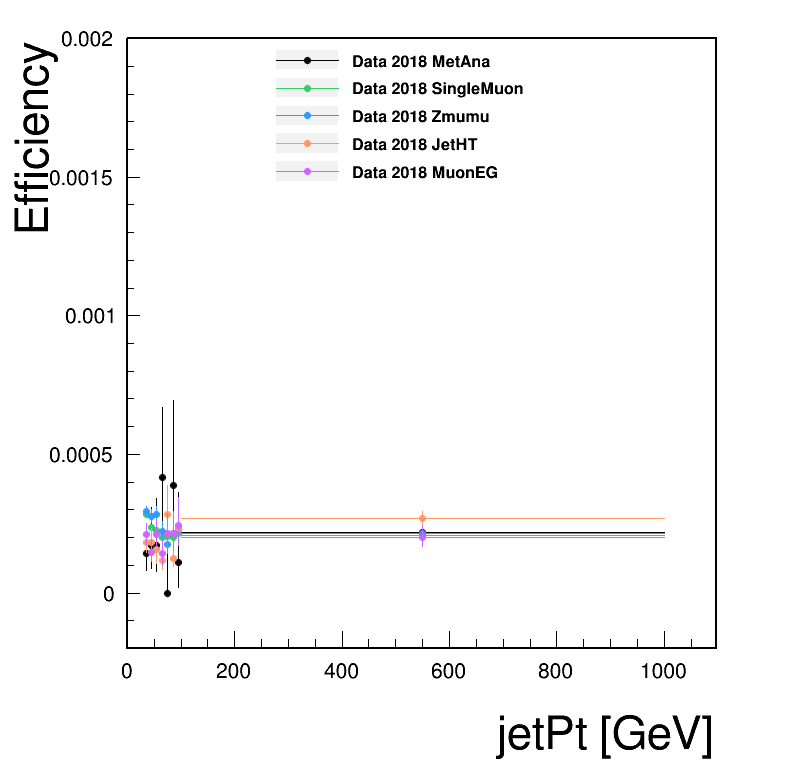

In [44]:

   

color_list = [1,845,861,806,876,597,625]

pEff = {}
for var in variables:
    print('var/x_axis', var[0], 'name', var[2], 'range',var[3],var[4])
    outf = 'tag_eff_jet_'+var[2]+'_rebin.png'

    c = rt.TCanvas('c','c', 800, 800)
    leg = rt.TLegend(0.33,0.76,0.78,0.94)
    leg.SetTextSize(0.022)
    leg.SetBorderSize(0)
    leg.SetEntrySeparation(0.01)
    i = 0
    for k,v in tree.items(): 
        print(k,v)
    

        if 'bb' not in k:
#         if 'QCD' in k:
            pEff[k] = var[1][k]
#             pEff[k] = rt.TEfficiency(eta_num_all[k], eta_den_all[k])
#             pEff[k] = rt.TEfficiency(pt_num_all[k], pt_den_all[k])
            pEff[k].SetTitle("efficiency;"+var[0]+";Efficiency")

            pEff[k].SetLineColor(color_list[i])
            pEff[k].SetMarkerColor(color_list[i])
            pEff[k].SetMarkerSize(0.8)
            pEff[k].SetMarkerStyle(20)

            if i==0:
                pEff[k].Draw("apez")
            else:
                pEff[k].Draw("pezsame")

            rt.gPad.Update()        
            #pEff[k].GetPaintedHistogram().GetXaxis().SetRangeUser(x[0],x[-1])
            pEff[k].GetPaintedGraph().SetMarkerStyle(8)
            pEff[k].GetPaintedGraph().SetMarkerSize(20)        
            pEff[k].GetPaintedGraph().SetLineColor(color_list[i])        
            pEff[k].GetPaintedGraph().SetMarkerColor(color_list[i])        
            pEff[k].GetPaintedGraph().SetMinimum(var[3])
            pEff[k].GetPaintedGraph().SetMaximum(var[4])
            pEff[k].GetPaintedGraph().GetXaxis().SetLabelSize(0.03)
            pEff[k].GetPaintedGraph().GetYaxis().SetLabelSize(0.03)


#             print('dim: ', pEff[k].GetDimension())
#             print('binN: ', pEff[k].GetPaintedGraph().GetN())
#             print('binN: ', pEff[k].GetPassedHistogram().GetNbinsX())
#             for cnt in range(len(x)):
#                 print(cnt)
#                 print('bin central x value: ', pEff[k].GetPassedHistogram().GetBinCenter(cnt))
#                 print('bin central y value: ', pEff[k].GetEfficiency(cnt))
#                 print('bin error y low: ', pEff[k].GetEfficiencyErrorLow(cnt))
#                 print('bin error y up: ', pEff[k].GetEfficiencyErrorUp(cnt))

            i += 1



            leg.AddEntry(pEff[k],k)

    leg.Draw()

#     c.SetLogx()
#     c.SetLogy()
    c.SetRightMargin(0.1)
    c.Update()
    c.Draw()
    c.SaveAs(plotDir+outf)


var/x_axis jetPt [GeV] name pt range -0.0002 0.002
Data 2018 MetAna <TTree b'SusyLLPPFTree' at 0x7fdc4dd991d0>
Data 2018 SingleMuon <TTree b'SusyLLPPFTree' at 0x7fdcc1de0160>
Data 2018 Zmumu <TTree b'SusyLLPPFTree' at 0x7fdcc2002668>
Data 2018 JetHT <TTree b'SusyLLPPFTree' at 0x7fdc4dd37668>
Data 2018 MuonEG <TTree b'SusyLLPPFTree' at 0x7fdcbc1a20b8>


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20210218/2018/Data_CR/tag_eff_jet_pt_rebin_logX.png has been created


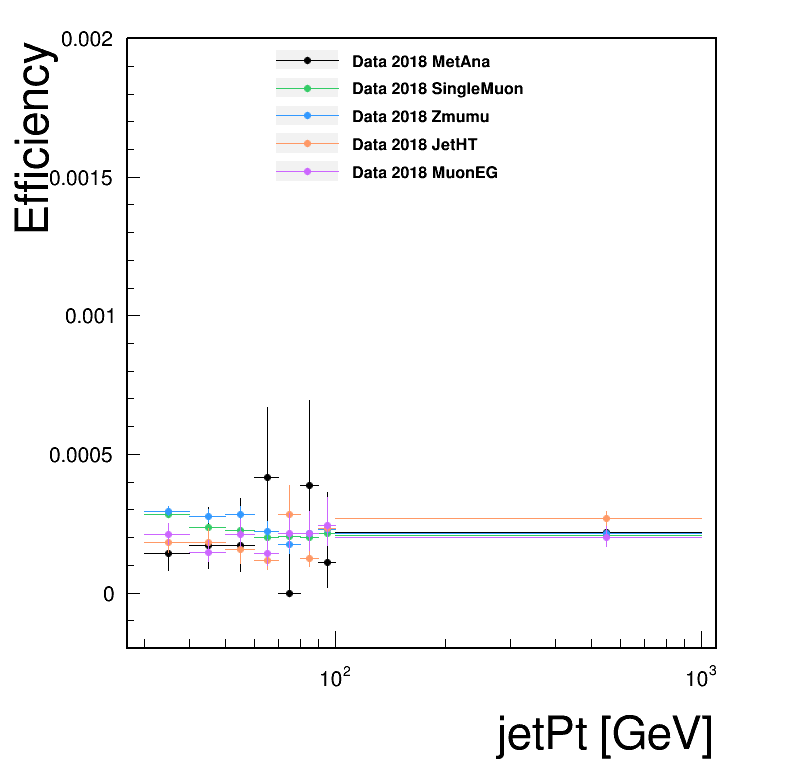

In [46]:

   

color_list = [1,845,861,806,876,597,625]

pEff = {}
for var in variables:
    print('var/x_axis', var[0], 'name', var[2], 'range',var[3],var[4])
#     outf = 'tag_eff_jet_'+var[2]+'_pt100.png'
#     outf = 'tag_eff_jet_'+var[2]+'_rebin.png'
    outf = 'tag_eff_jet_'+var[2]+'_rebin_logX.png'
#     outf = 'tag_eff_jet_'+var[2]+'_rebin_comparison.png'
#     outf = 'tag_eff_jet_'+var[2]+'_rebin_2017_2018.png'
#     outf = 'tag_eff_jet_'+var[2]+'.png'
    c = rt.TCanvas('c','c', 800, 800)
    leg = rt.TLegend(0.33,0.76,0.78,0.94)
    leg.SetTextSize(0.022)
    leg.SetBorderSize(0)
    leg.SetEntrySeparation(0.01)
    i = 0
    for k,v in tree.items(): 
        print(k,v)


        if 'bb' not in k:
#         if 'QCD' in k:
            pEff[k] = var[1][k]
#             pEff[k] = rt.TEfficiency(eta_num_all[k], eta_den_all[k])
#             pEff[k] = rt.TEfficiency(pt_num_all[k], pt_den_all[k])
            pEff[k].SetTitle("efficiency;"+var[0]+";Efficiency")

            pEff[k].SetLineColor(color_list[i])
            pEff[k].SetMarkerColor(color_list[i])
            pEff[k].SetMarkerSize(0.8)
            pEff[k].SetMarkerStyle(20)

            if i==0:
                pEff[k].Draw("apez")
            else:
                pEff[k].Draw("pezsame")

            rt.gPad.Update()        
            #pEff[k].GetPaintedHistogram().GetXaxis().SetRangeUser(x[0],x[-1])
            pEff[k].GetPaintedGraph().SetMarkerStyle(8)
            pEff[k].GetPaintedGraph().SetMarkerSize(20)        
            pEff[k].GetPaintedGraph().SetLineColor(color_list[i])        
            pEff[k].GetPaintedGraph().SetMarkerColor(color_list[i])        
            pEff[k].GetPaintedGraph().SetMinimum(var[3])
            pEff[k].GetPaintedGraph().SetMaximum(var[4])
            pEff[k].GetPaintedGraph().GetXaxis().SetLabelSize(0.03)
            pEff[k].GetPaintedGraph().GetYaxis().SetLabelSize(0.03)


#             print('dim: ', pEff[k].GetDimension())
#             print('binN: ', pEff[k].GetPaintedGraph().GetN())
#             print('binN: ', pEff[k].GetPassedHistogram().GetNbinsX())
#             for cnt in range(len(x)):
#                 print(cnt)
#                 print('bin central x value: ', pEff[k].GetPassedHistogram().GetBinCenter(cnt))
#                 print('bin central y value: ', pEff[k].GetEfficiency(cnt))
#                 print('bin error y low: ', pEff[k].GetEfficiencyErrorLow(cnt))
#                 print('bin error y up: ', pEff[k].GetEfficiencyErrorUp(cnt))

            i += 1



            leg.AddEntry(pEff[k],k)

    leg.Draw()

    c.SetLogx()
#     c.SetLogy()
    c.SetRightMargin(0.1)
    c.Update()
    c.Draw()
    c.SaveAs(plotDir+outf)


In [47]:
variables = [
    
 
        ['jetPt [GeV]', pt_denall, 50, 0, 2000],
      
    
 
]

var/x_axis jetPt [GeV] name 50 range 0 2000
Data 2018 MetAna <TTree b'SusyLLPPFTree' at 0x7fdc4dd991d0>
Data 2018 SingleMuon <TTree b'SusyLLPPFTree' at 0x7fdcc1de0160>
Data 2018 Zmumu <TTree b'SusyLLPPFTree' at 0x7fdcc2002668>
Data 2018 JetHT <TTree b'SusyLLPPFTree' at 0x7fdc4dd37668>
Data 2018 MuonEG <TTree b'SusyLLPPFTree' at 0x7fdcbc1a20b8>


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20210218/2018/Data_CR/pt_jet.png has been created


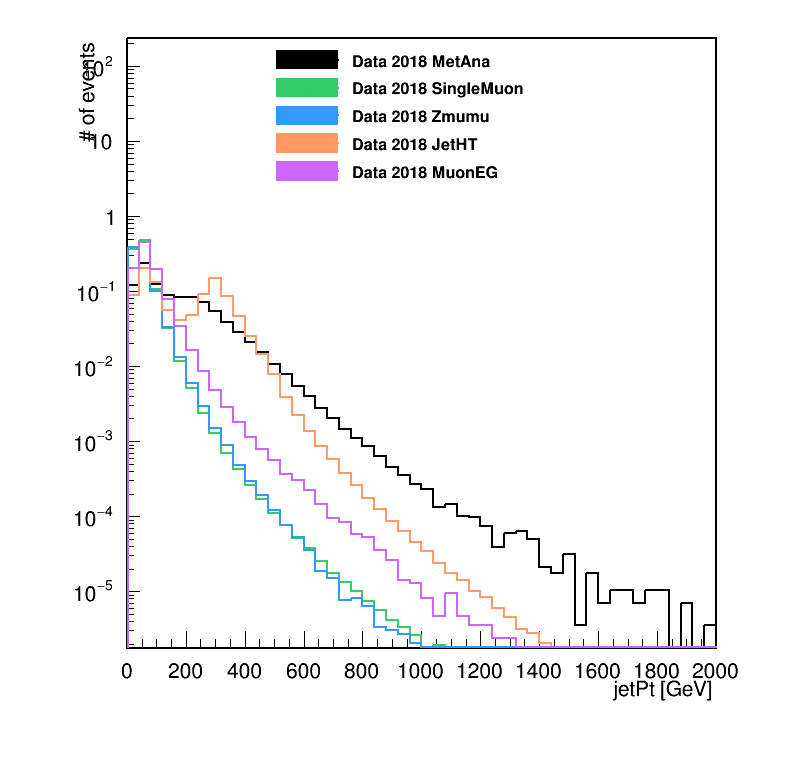

In [48]:

   

color_list = [1,845,861,806,876,597,625]

ptHist= {}
peHist= {}
for var in variables:
    print('var/x_axis', var[0], 'name', var[2], 'range',var[3],var[4])
    outf = 'pt_jet.png'
    c = rt.TCanvas('c','c', 800, 800)
    leg = rt.TLegend(0.33,0.76,0.78,0.94)
    leg.SetTextSize(0.022)
    leg.SetBorderSize(0)
    leg.SetEntrySeparation(0.01)
    i = 0
    for k,v in tree.items(): 
        print(k,v)


        if 'bb' not in k:
            ptHist[k] = create_TH1D( var[1][k], axis_title=[var[0], '# of events'], name="", binning=[var[2],var[3],var[4]], weights=wall[k])
           

            ptHist[k].SetLineColor(color_list[i])
            ptHist[k].SetMarkerColor(color_list[i])
            ptHist[k].SetMarkerSize(0.8)
#             ptHist[k].SetMarkerStyle(20)

#             if i==0:
#                 ptHist[k].Draw("ahist")
#             else:
#                 ptHist[k].Draw("histsame")

#            ptHist[k].Sumw2()
          
            ptHist[k].GetXaxis().SetTitleSize(0.03)
            ptHist[k].GetYaxis().SetTitleSize(0.03)
            ptHist[k].GetXaxis().SetLabelSize(0.03)
            ptHist[k].GetYaxis().SetLabelSize(0.03)
            ptHist[k].SetMaximum(1e+3*(ptHist[k].GetMaximum()))
            ptHist[k].DrawNormalized("Hist same")

            peHist[k] =ptHist[k].Clone()
            peHist[k].SetFillColor(color_list[i])
            #            peHist[k].Draw("e2 same")

            leg.AddEntry(peHist[k],k )


            i += 1



#             leg.AddEntry(pEff[k],k)

    leg.Draw()

#     c.SetLogx()
    c.SetLogy()
    c.SetRightMargin(0.1)
    c.Update()
    c.Draw()
    c.SaveAs(plotDir+outf)


In [49]:
variables = [
    
 
        ['jetPt [GeV]', pt_numall, 50, 0, 2000],
      
    
 
]

var/x_axis jetPt [GeV] name 50 range 0 2000
Data 2018 MetAna <TTree b'SusyLLPPFTree' at 0x7fdc4dd991d0>
Data 2018 SingleMuon <TTree b'SusyLLPPFTree' at 0x7fdcc1de0160>
Data 2018 Zmumu <TTree b'SusyLLPPFTree' at 0x7fdcc2002668>
Data 2018 JetHT <TTree b'SusyLLPPFTree' at 0x7fdc4dd37668>
Data 2018 MuonEG <TTree b'SusyLLPPFTree' at 0x7fdcbc1a20b8>


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20210218/2018/Data_CR/pt_jet_pass.png has been created


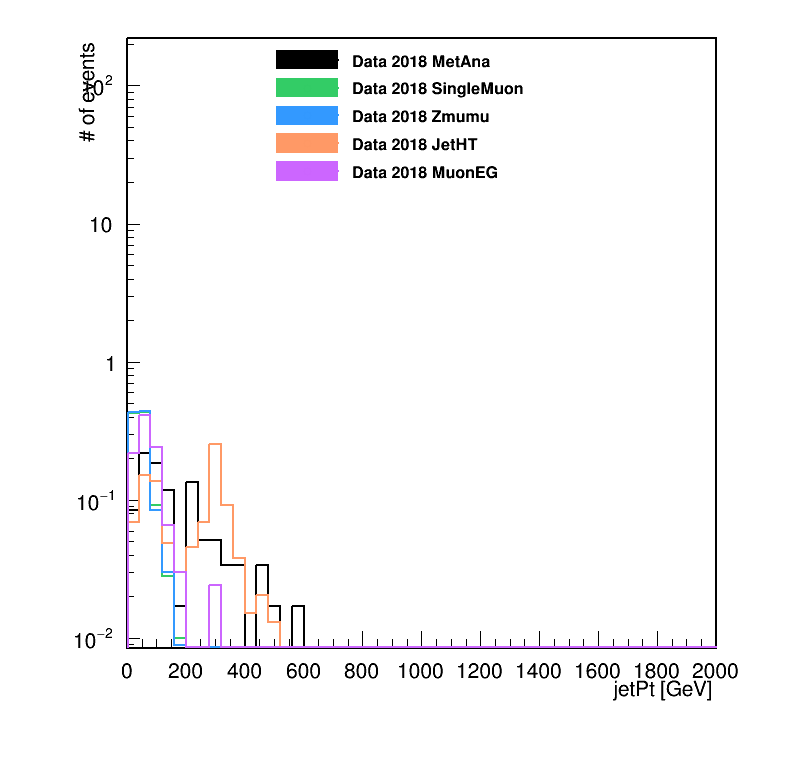

In [50]:

   

color_list = [1,845,861,806,876,597,625]

ptHist= {}
peHist= {}
for var in variables:
    print('var/x_axis', var[0], 'name', var[2], 'range',var[3],var[4])
    outf = 'pt_jet_pass.png'
    c = rt.TCanvas('c','c', 800, 800)
    leg = rt.TLegend(0.33,0.76,0.78,0.94)
    leg.SetTextSize(0.022)
    leg.SetBorderSize(0)
    leg.SetEntrySeparation(0.01)
    i = 0
    for k,v in tree.items(): 
        print(k,v)


        if 'bb' not in k:
            ptHist[k] = create_TH1D( var[1][k], axis_title=[var[0], '# of events'], name="", binning=[var[2],var[3],var[4]], weights=wnum[k])
           

            ptHist[k].SetLineColor(color_list[i])
#             ptHist[k].SetLineStyle(i+1)
            ptHist[k].SetMarkerColor(color_list[i])
            ptHist[k].SetMarkerSize(0.8)
            ptHist[k].SetMarkerStyle(20)

#             if i==0:
#                 ptHist[k].Draw("ahist")
#             else:
#                 ptHist[k].Draw("histsame")

#            ptHist[k].Sumw2()
          
            ptHist[k].GetXaxis().SetTitleSize(0.03)
            ptHist[k].GetYaxis().SetTitleSize(0.03)
            ptHist[k].GetXaxis().SetLabelSize(0.03)
            ptHist[k].GetYaxis().SetLabelSize(0.03)
            ptHist[k].SetMaximum(1e+3*(ptHist[k].GetMaximum()))
            ptHist[k].DrawNormalized("Hist same")

            peHist[k] =ptHist[k].Clone()
            peHist[k].SetFillColor(color_list[i])
            #            peHist[k].Draw("e2 same")

            leg.AddEntry(peHist[k],k )


            i += 1



#             leg.AddEntry(pEff[k],k)

    leg.Draw()

#     c.SetLogx()
    c.SetLogy()
    c.SetRightMargin(0.1)
    c.Update()
    c.Draw()
    c.SaveAs(plotDir+outf)


## Dphi

In [51]:
variables = [
    
 
#         ['DeltaPhi(jet1, jet2)', trg_jet_dphi_jet, 50, 0, 3.15],
        ['MinDeltaPhi(jet, met)', trg_jet_dphi_met, 50, 0, 3.15],
      
    
 
]

var/x_axis MinDeltaPhi(jet, met) name 50 range 0 3.15
Data 2018 MetAna <TTree b'SusyLLPPFTree' at 0x7fdc4dd991d0>
Data 2018 SingleMuon <TTree b'SusyLLPPFTree' at 0x7fdcc1de0160>
Data 2018 Zmumu <TTree b'SusyLLPPFTree' at 0x7fdcc2002668>
Data 2018 JetHT <TTree b'SusyLLPPFTree' at 0x7fdc4dd37668>
Data 2018 MuonEG <TTree b'SusyLLPPFTree' at 0x7fdcbc1a20b8>


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20210218/2018/Data_CR/dphi_jet_met.png has been created


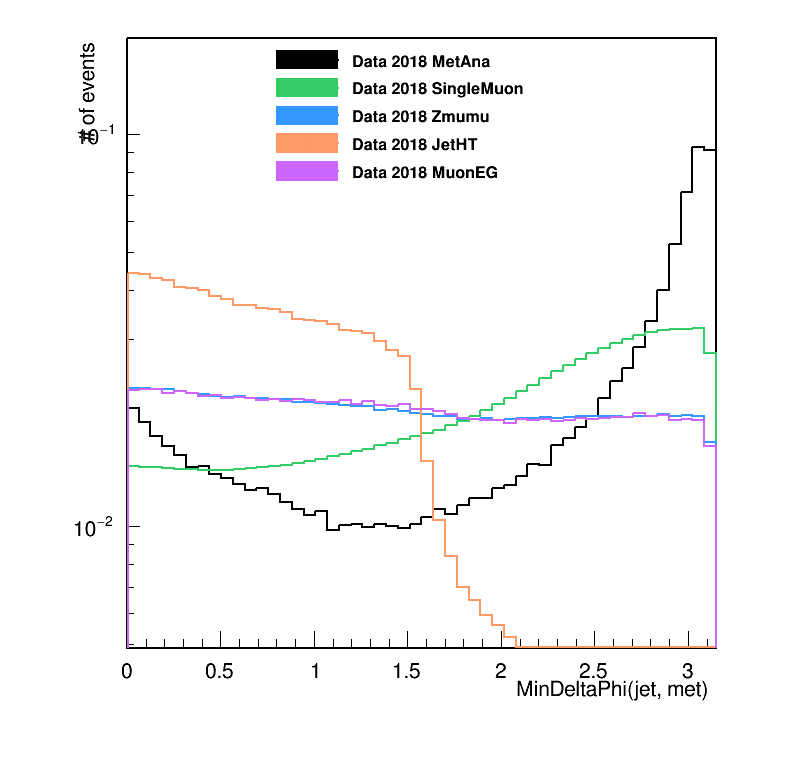

In [52]:

   

color_list = [1,845,861,806,876,597,625]

ptHist= {}
peHist= {}
for var in variables:
    print('var/x_axis', var[0], 'name', var[2], 'range',var[3],var[4])
#     outf = 'dphi_jet_jet.png'
    outf = 'dphi_jet_met.png'
    c = rt.TCanvas('c','c', 800, 800)
    leg = rt.TLegend(0.33,0.76,0.78,0.94)
    leg.SetTextSize(0.022)
    leg.SetBorderSize(0)
    leg.SetEntrySeparation(0.01)
    i = 0
    for k,v in tree.items(): 
        print(k,v)


        if 'bb' not in k:
            if 'MC' in k:
                w_plot = trg_jet_w[k]*trg_jet_pu[k]
            else:
                w_plot = trg_jet_w[k] 
            
            ptHist[k] = create_TH1D( var[1][k], axis_title=[var[0], '# of events'], name="", binning=[var[2],var[3],var[4]], weights=w_plot)
           

            ptHist[k].SetLineColor(color_list[i])
#             ptHist[k].SetLineStyle(i+1)
            ptHist[k].SetMarkerColor(color_list[i])
            ptHist[k].SetMarkerSize(0.8)
            ptHist[k].SetMarkerStyle(20)

#             if i==0:
#                 ptHist[k].Draw("ahist")
#             else:
#                 ptHist[k].Draw("histsame")

#            ptHist[k].Sumw2()
          
            ptHist[k].GetXaxis().SetTitleSize(0.03)
            ptHist[k].GetYaxis().SetTitleSize(0.03)
            ptHist[k].GetXaxis().SetLabelSize(0.03)
            ptHist[k].GetYaxis().SetLabelSize(0.03)
#             ptHist[k].SetMaximum(1e+3*(ptHist[k].GetMaximum()))
#             ptHist[k].Draw("Hist same")
            ptHist[k].DrawNormalized("Hist same")

            peHist[k] =ptHist[k].Clone()
            peHist[k].SetFillColor(color_list[i])
            #            peHist[k].Draw("e2 same")

            leg.AddEntry(peHist[k],k )


            i += 1



#             leg.AddEntry(pEff[k],k)

    leg.Draw()

#     c.SetLogx()
    c.SetLogy()
    c.SetRightMargin(0.1)
    c.Update()
    c.Draw()
    c.SaveAs(plotDir+outf)
